# ネットワーク読み込み

In [15]:
import pypsa

# 最適化済みネットワークデータを読み込む
network = pypsa.Network('./complete_network/optimized_network_2024.nc')
print(f"ネットワークデータを読み込みました: {len(network.buses)} buses, {len(network.generators)} generators")

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks


ネットワークデータを読み込みました: 49 buses, 239 generators


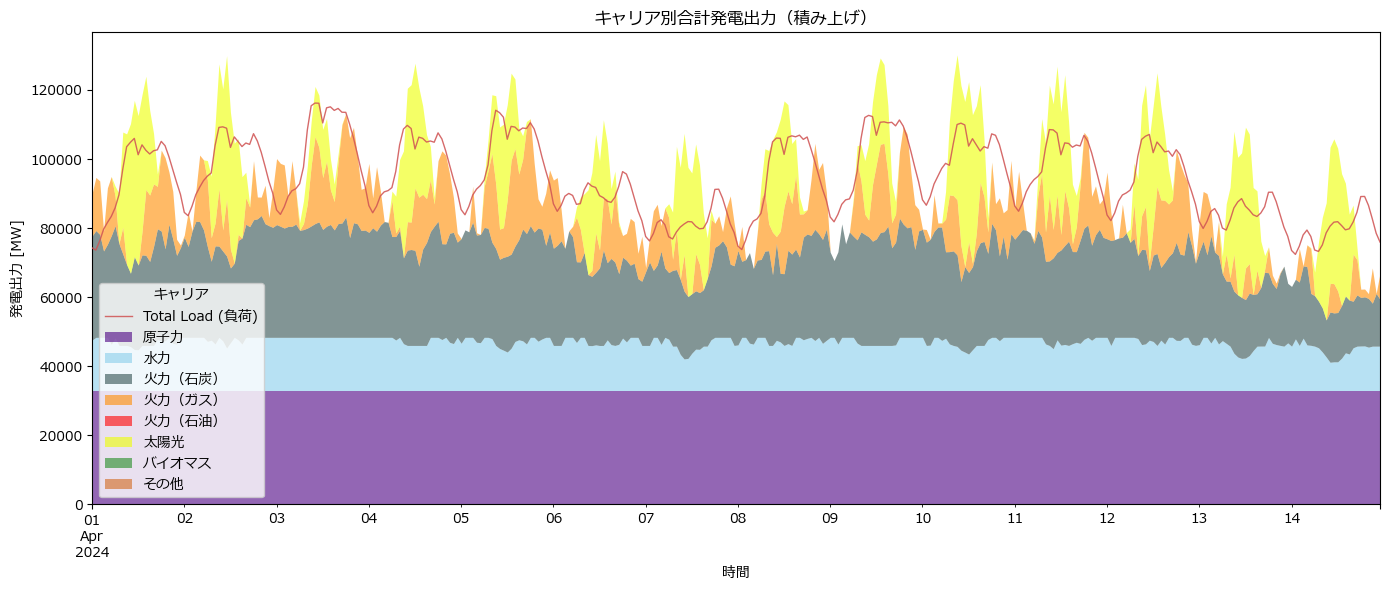

In [16]:
# モジュールを強制的にリロード
import pypsa_tepsco
import importlib
importlib.reload(pypsa_tepsco)
pypsa_tepsco.plot_total_generation_by_carrier(network)

Total Curtailment by Generator (MWh):
name
太陽光(九州)     1.714347e+05
太陽光(北陸)     5.227540e+03
太陽光(中部)     3.879563e-12
太陽光(東京)     1.676881e-12
太陽光(関西)     1.413980e-12
太陽光（東北）     1.307399e-12
太陽光（北海道）    6.394885e-13
太陽光(中国)     4.547474e-13
dtype: float64


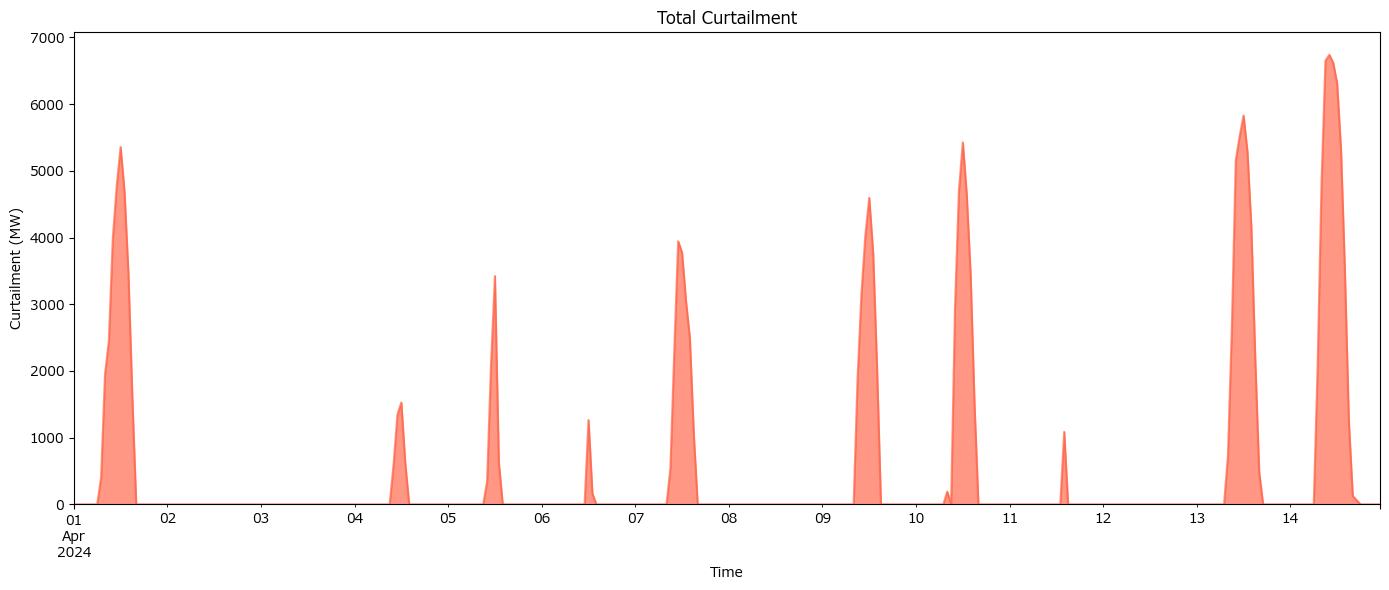

In [20]:
import matplotlib.pyplot as plt

# ネットワークの出力抑制（curtailment）を計算して表示
curtailment = network.generators_t.p_max_pu * network.generators.p_nom - network.generators_t.p

# 各発電機の合計出力抑制量を表示
total_curtailment = curtailment.sum()
print("Total Curtailment by Generator (MWh):")
print(total_curtailment[total_curtailment > 0].sort_values(ascending=False))

# 時系列の出力抑制をプロット
curtailment_positive = curtailment.clip(lower=0)
fig, ax = plt.subplots(figsize=(14, 6))
curtailment_positive.sum(axis=1).plot.area(ax=ax, title='Total Curtailment',
                                       ylabel='Curtailment (MW)', xlabel='Time', 
                                       stacked=True, color='#FF6347AA')
plt.tight_layout()
plt.show()

# 送電線の潮流を表示

プロット対象の連系線: 10本
['北海道本州連系設備', '東北東京間連系線', '東京中部間連系線', '中部北陸連系設備', '中部関西連系線', '北陸関西連系線', '関西中国間連系線', '関西四国間連系設備', '中国四国間連系線', '中国九州間連系線']


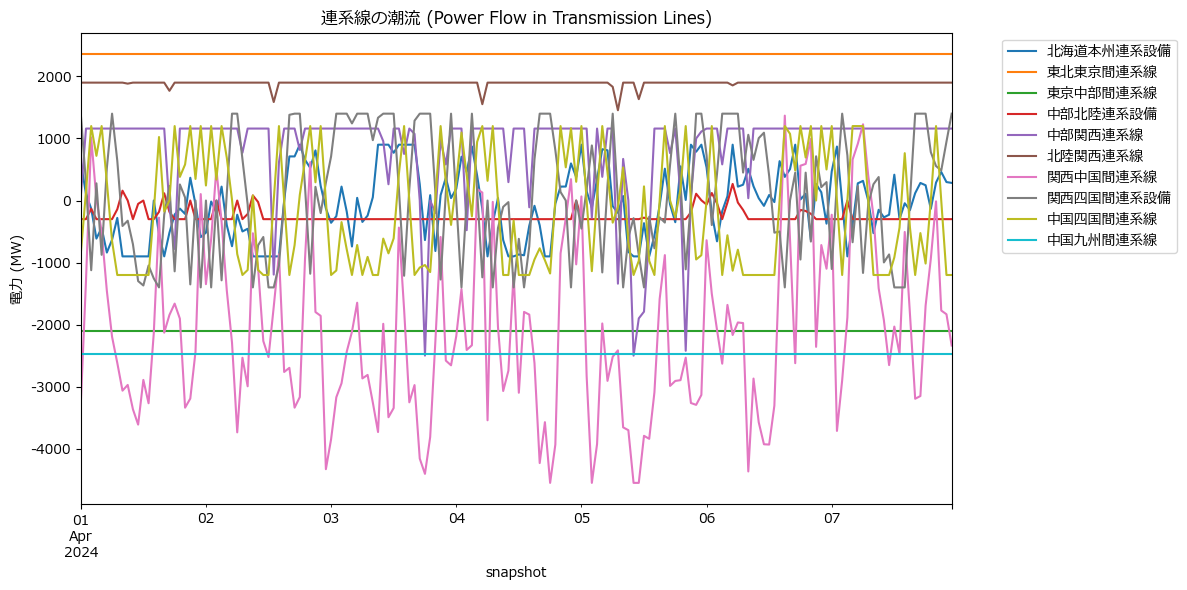

In [4]:
import pandas as pd

pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止

# 連系線のみをフィルタリング（carrier='DC'または名前に'連系'を含むリンク）
transmission_links = network.links[
    (network.links['carrier'] == 'DC') | 
    (network.links.index.str.contains('連系', na=False))
].index

if len(transmission_links) > 0:
    network.links_t.p0[transmission_links].plot(
        title="連系線の潮流 (Power Flow in Transmission Lines)", 
        figsize=(12, 6),
        ylabel="電力 (MW)"
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    print(f"プロット対象の連系線: {len(transmission_links)}本")
    print(transmission_links.tolist())
else:
    print("連系線が見つかりませんでした")

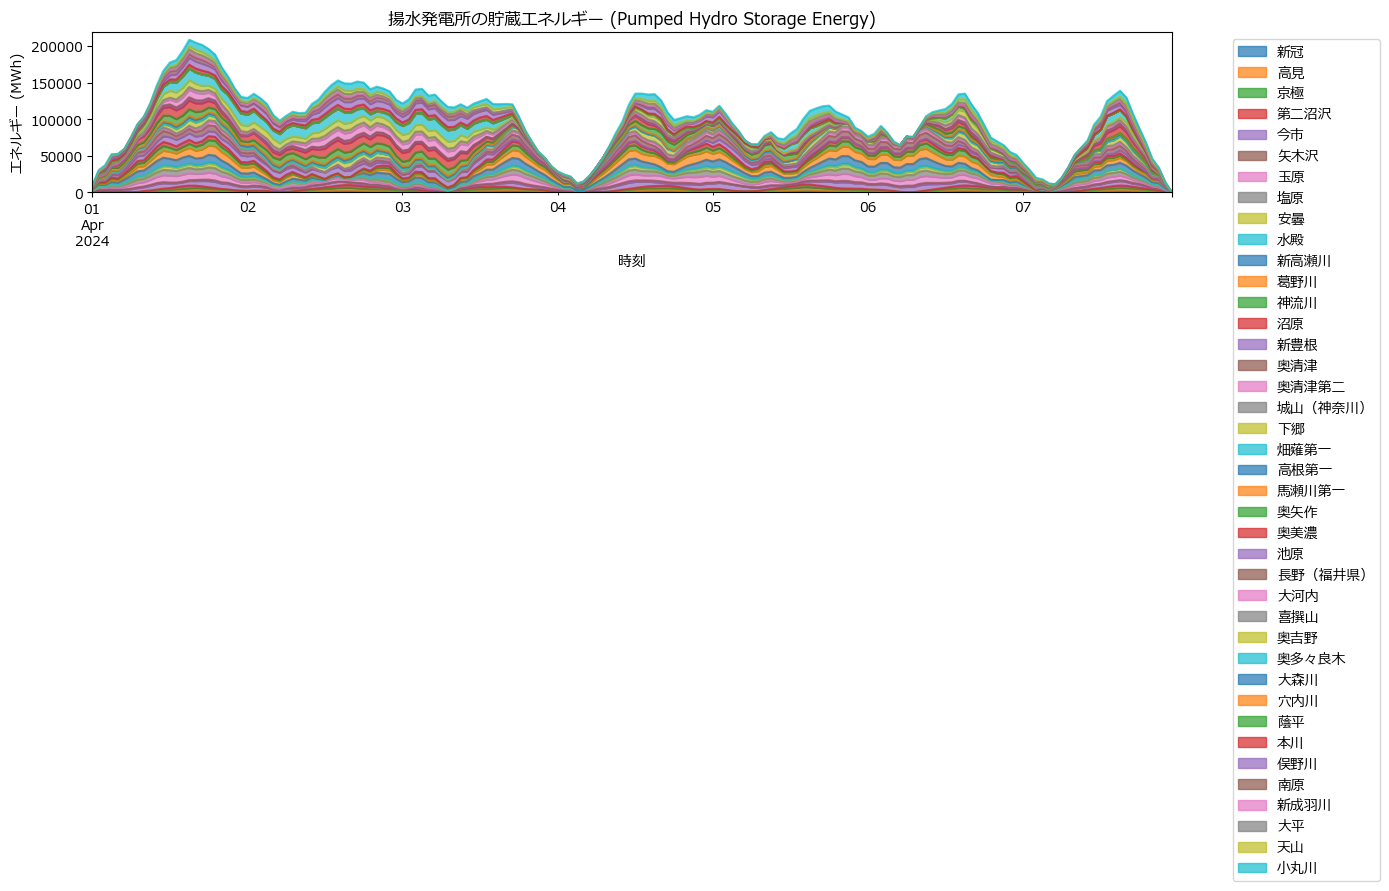

揚水発電所の数: 40

各揚水発電所の最大・最小・平均貯蔵エネルギー (MWh):
name           新冠           高見          京極         第二沼沢           今市  \
min     -0.000000    -0.000000    -0.00000    -0.000000    -0.000000   
max   1600.000000  1712.000000  3762.75000  3680.000000  8400.000000   
mean   698.525893   664.000595  1513.31625  1621.685374  4223.119744   

name          矢木沢           玉原           塩原           安曇           水殿  ...  \
min     -0.000000    -0.000000    -0.000000    -0.000000    -0.000000  ...   
max   1920.000000  9600.000000  7200.000000  4984.000000  1960.000000  ...   
mean  1009.285714  4978.752411  3786.512012  2502.566435   924.658155  ...   

name       大森川         穴内川          蔭平           本川          俣野川           南原  \
min   -0.00000   -0.000000   -0.000000    -0.000000    -0.000000    -0.000000   
max   96.00000  104.000000  376.000000  4920.000000  9600.000000  4960.000000   
mean  35.77381   40.980655  155.044643  1922.695332  3932.190998  1798.781144   

name         新成羽川           大平

In [5]:
# 揚水発電所の貯蔵エネルギー（蓄電状態）を積み上げグラフでプロット
if len(network.stores) > 0:
    # 揚水発電所（Store）の蓄電量時系列データを取得
    storage_energy = network.stores_t.e
    
    if not storage_energy.empty:
        fig, ax = plt.subplots(figsize=(14, 6))
        storage_energy.plot(
            ax=ax, 
            kind='area',
            stacked=True,
            alpha=0.7,
            title='揚水発電所の貯蔵エネルギー (Pumped Hydro Storage Energy)', 
            ylabel='エネルギー (MWh)', 
            xlabel='時刻'
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        print(f"揚水発電所の数: {len(network.stores)}")
        print("\n各揚水発電所の最大・最小・平均貯蔵エネルギー (MWh):")
        print(storage_energy.describe().loc[['min', 'max', 'mean']])
    else:
        print("揚水発電所の貯蔵エネルギーデータがありません")
else:
    print("ネットワークに揚水発電所（Store）が含まれていません")

In [6]:
# 揚水発電所のリンク（発電・揚水）の出力をプロット
if len(pumped_hydro_links) > 0:
    # 揚水発電所の出力時系列データを取得
    pumped_hydro_power = network.links_t.p0[pumped_hydro_links]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    pumped_hydro_power.plot(ax=ax, title='揚水発電所の出力 (Pumped Hydro Power Output)', 
                            ylabel='電力 (MW)', xlabel='時刻', legend=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print(f"揚水発電所の数: {len(pumped_hydro_links)}")
    print("\n各揚水発電所の出力統計 (MW):")
    print(pumped_hydro_power.describe().loc[['min', 'max', 'mean']])
    
    # 正の値（発電）と負の値（揚水）を分けて集計
    generation = pumped_hydro_power.clip(lower=0).sum().sum()
    pumping = pumped_hydro_power.clip(upper=0).sum().sum()
    print(f"\n総発電量: {generation:.2f} MWh")
    print(f"総揚水量: {pumping:.2f} MWh")
else:
    print("揚水発電所のリンクが見つかりませんでした")

NameError: name 'pumped_hydro_links' is not defined

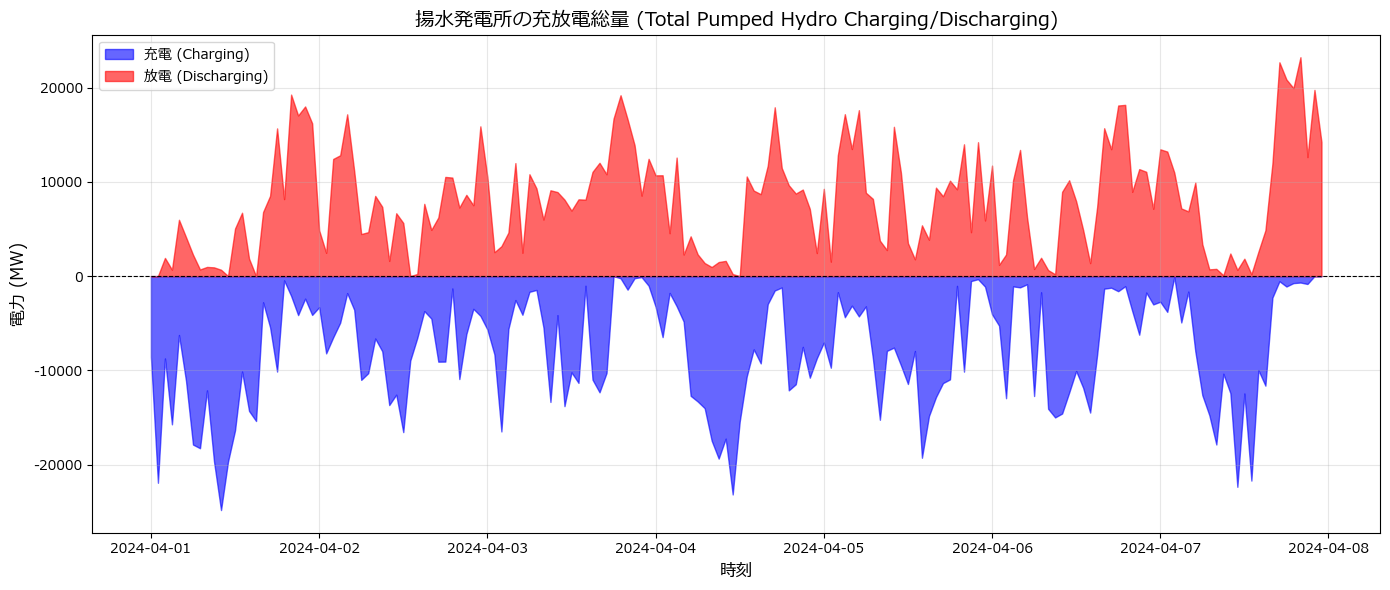


総充電量: 1342369.84 MWh
総放電量: 1342369.84 MWh
エネルギー効率: 100.00%


In [90]:
# 揚水発電所の充電（負値）と放電（正値）を分けて集計してプロット
if len(pumped_hydro_links) > 0:
    # 充電量（負の値）と放電量（正の値）を分離
    charging = pumped_hydro_power.clip(upper=0).sum(axis=1)  # 負の値（充電）
    discharging = pumped_hydro_power.clip(lower=0).sum(axis=1)  # 正の値（放電）
    
    # プロット
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.fill_between(charging.index, charging, 0, alpha=0.6, color='blue', label='充電 (Charging)')
    ax.fill_between(discharging.index, 0, discharging, alpha=0.6, color='red', label='放電 (Discharging)')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('揚水発電所の充放電総量 (Total Pumped Hydro Charging/Discharging)', fontsize=14)
    ax.set_ylabel('電力 (MW)', fontsize=12)
    ax.set_xlabel('時刻', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 統計情報を表示
    total_charging = charging.sum()
    total_discharging = discharging.sum()
    print(f"\n総充電量: {abs(total_charging):.2f} MWh")
    print(f"総放電量: {total_discharging:.2f} MWh")
    print(f"エネルギー効率: {(total_discharging / abs(total_charging) * 100):.2f}%")
else:
    print("揚水発電所のリンクが見つかりませんでした")

# 地図上にプロットする。

In [35]:
import folium
import pandas as pd

# Helper: try various column names and return DataFrame with lat/lon
def _get_bus_locations_df(network):
    df = network.buses.copy()
    # common PyPSA default: x (lon), y (lat)
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    # already lat/lon
    elif {'lat','lon'}.issubset(df.columns):
        pass
    # alternative naming
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    # some workflows store coords in a list/tuple column called 'coords'
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    # ensure numeric and drop invalid rows
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# get bus locations (raises helpful error if not found)
bus_locations = _get_bus_locations_df(network)

# 地図の中心をバスの平均位置に設定
center_lat = bus_locations['lat'].mean()
center_lon = bus_locations['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# バスごとにマーカーを追加
for bus_name, row in bus_locations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=str(bus_name),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# 保存と表示
m.save('bus_locations_map.html')

m

In [36]:
# プロット: バスとリンク（network.links / network.lines）を地図上に描画して保存
# 既に folium, network, Year_of_analysis が定義されている前提
import folium

# 再利用可能なバス位置取得関数 (cell '#VSC-50c70af2' と同じロジック)
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# バス位置取得
bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        # bus 名が bus_locations にあるか確認
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

# network.links があれば描画
links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

# network.lines があれば描画（存在するネットワークでは lines が無い場合もある）
if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

# 出力・保存
out_file = f'bus_links_map_{Year_of_analysis}.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

# Jupyter で表示するためにマップオブジェクトを返す
m_links


NameError: name 'Year_of_analysis' is not defined

In [ ]:
# Duplicate plotting cell made robust as well
import folium

# re-use the helper from earlier; define again to be safe in isolation
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

out_file = f'bus_links_map_{Year_of_analysis}.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

m_links


# 太陽光データをRenewable.Ninjaから取得してCSVに保存する。

# 以下はRenewable.Ninjaのデータが↑のコードで取得できることが確認できたら削除可能

In [33]:
# pypsa-japan-10BusModel.xlsx のbusesのバス名と座標を取得して、年間の時系列データを取得してCSVに保存

file_name = 'pypsa-japan-10BusModel.xlsx'
output_file = './data/processed/solar_time_series.csv'
Year_of_analysis = 2024
import pandas as pd
import requests
renewable_ninja_api_key = '0ee68c7853037dcd2235f771d349d104e68996cf'

# ネットワークファイルからバス情報を読み込み
buses_df = pd.read_excel(file_name, sheet_name='buses')
buses_df = buses_df.set_index('name')

# 座標情報を含むバス位置データフレームを作成
bus_coords = buses_df[['y', 'x']].copy()
bus_coords.columns = ['lat', 'lon']
bus_coords = bus_coords.dropna()

print(f"取得したバス数: {len(bus_coords)}")
print(bus_coords)

# 年間の日付範囲を作成（JSTで最終的に必要な範囲）
annual_snapshots = pd.date_range(f"{Year_of_analysis}-01-01 00:00",
                                  f"{Year_of_analysis}-12-31 23:00",
                                  freq="h")

# 結果を格納するDataFrame
solar_data_annual_full = pd.DataFrame(index=annual_snapshots)

# 各バスの座標に対してRenewable.Ninja APIからデータを取得
for bus_name, row in bus_coords.iterrows():
    lat = row['lat']
    lon = row['lon']
    
    print(f"Fetching data for {bus_name} (lat: {lat}, lon: {lon})...")
    
    # Renewable.Ninja API リクエスト
    # JSTへの変換で9時間進むため、前日の15:00 UTCから取得開始
    # （前日の15:00 UTC = 当日の0:00 JST）
    url = 'https://www.renewables.ninja/api/data/pv'
    params = {
        'lat': lat,
        'lon': lon,
        'date_from': f'{Year_of_analysis - 1}-12-31',  # 前年の12/31から取得
        'date_to': f'{Year_of_analysis}-12-31',
        'dataset': 'merra2',
        'capacity': 1.0,
        'system_loss': 0.1,
        'tracking': 0,
        'tilt': 35,
        'azim': 180,
        'format': 'json'
    }
    headers = {'Authorization': f'Token {renewable_ninja_api_key}'}
    
    response = requests.get(url, params=params, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        # レスポンス構造を確認してデバッグ
        if isinstance(data, dict) and 'data' in data:
            # 辞書形式のレスポンス (時刻がキーの場合)
            if isinstance(data['data'], dict):
                # Unix時間(ミリ秒)をdatetimeに変換
                time_keys = list(data['data'].keys())
                # キーが数値(Unix時間)かどうか確認
                if time_keys and str(time_keys[0]).isdigit():
                    # Unix時間(ミリ秒)の場合
                    time_index = pd.to_datetime([int(k) for k in time_keys], unit='ms')
                else:
                    # 文字列形式の場合
                    time_index = pd.to_datetime(time_keys)
                # JSTに変換（UTC+9時間）
                time_index = time_index.tz_localize('UTC').tz_convert('Asia/Tokyo').tz_localize(None)
                values = list(data['data'].values())
                # 辞書から数値を抽出 (PyPSA形式)
                if values and isinstance(values[0], dict):
                    values = [v.get('electricity', v) if isinstance(v, dict) else v for v in values]
                # 時刻インデックスと値を組み合わせて、annual_snapshotsの範囲にリインデックス
                temp_series = pd.Series(values, index=time_index)
                solar_data_annual_full[bus_name] = temp_series.reindex(annual_snapshots, fill_value=0)
            # リスト形式のレスポンス (DataFrame変換可能な場合)
            elif isinstance(data['data'], list):
                df_temp = pd.DataFrame(data['data'])
                # 時刻カラム名を探す
                time_col = next((col for col in df_temp.columns if 'time' in col.lower()), None)
                if time_col:
                    df_temp.index = pd.to_datetime(df_temp[time_col])
                # 発電量カラム名を探す
                elec_col = next((col for col in df_temp.columns if 'electric' in col.lower() or 'power' in col.lower()), df_temp.columns[1] if len(df_temp.columns) > 1 else df_temp.columns[0])
                solar_data_annual_full[bus_name] = df_temp[elec_col]
        else:
            print(f"  ⚠ Unexpected response format for {bus_name}")
            solar_data_annual_full[bus_name] = 0
        print(f"  ✓ Success for {bus_name}")
    else:
        print(f"  ✗ Failed for {bus_name}: {response.status_code}")
        solar_data_annual_full[bus_name] = 0

# PyPSA形式のCSVとして保存（数値のみ、UTF-8エンコーディング）

solar_data_annual_full.to_csv(output_file, encoding='utf-8-sig')
print(f"\n年間太陽光データ(PyPSA形式)を保存しました: {output_file}")
print(f"データサイズ: {solar_data_annual_full.shape}")
print("\n最初の5行:")
print(solar_data_annual_full.head())
print("\n統計情報:")
print(solar_data_annual_full.describe())

取得したバス数: 9
        lat     lon
name               
北海道   43.07  141.40
東北    38.28  140.91
東京    35.67  139.82
中部    35.18  137.01
北陸    36.70  137.22
関西    34.73  135.95
中国    34.39  132.46
四国    34.35  134.05
九州    33.58  130.41
Fetching data for 北海道 (lat: 43.07, lon: 141.4)...
  ✗ Failed for 北海道: 429
Fetching data for 東北 (lat: 38.28, lon: 140.91)...
  ✗ Failed for 北海道: 429
Fetching data for 東北 (lat: 38.28, lon: 140.91)...
  ✗ Failed for 東北: 429
Fetching data for 東京 (lat: 35.67, lon: 139.82)...
  ✗ Failed for 東北: 429
Fetching data for 東京 (lat: 35.67, lon: 139.82)...
  ✗ Failed for 東京: 429
Fetching data for 中部 (lat: 35.18, lon: 137.01)...
  ✗ Failed for 東京: 429
Fetching data for 中部 (lat: 35.18, lon: 137.01)...
  ✗ Failed for 中部: 429
Fetching data for 北陸 (lat: 36.7, lon: 137.22)...
  ✗ Failed for 中部: 429
Fetching data for 北陸 (lat: 36.7, lon: 137.22)...
  ✗ Failed for 北陸: 429
Fetching data for 関西 (lat: 34.73, lon: 135.95)...
  ✗ Failed for 北陸: 429
Fetching data for 関西 (lat: 34.73, lon: 